<a href="https://colab.research.google.com/github/sakchy/Pytorch_Cartoonizer/blob/master/Cartoonizer_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
! wget 'https://github.com/SystemErrorWang/FacialCartoonization/blob/master/weight.pth?raw=true' -O weight.pth
! wget 'https://www.pinkvilla.com/files/styles/contentpreview/public/sushantsingh_rajput_was_designing_a_game_and_printer_of_his_own_reveals_a_producer_friend.jpg?itok=itj5vDeZ' -O image.jpg

--2020-08-22 21:31:18--  https://github.com/SystemErrorWang/FacialCartoonization/blob/master/weight.pth?raw=true
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/SystemErrorWang/FacialCartoonization/raw/master/weight.pth [following]
--2020-08-22 21:31:18--  https://github.com/SystemErrorWang/FacialCartoonization/raw/master/weight.pth
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/SystemErrorWang/FacialCartoonization/master/weight.pth [following]
--2020-08-22 21:31:19--  https://raw.githubusercontent.com/SystemErrorWang/FacialCartoonization/master/weight.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.1

In [18]:
import os
import cv2
import torch
import numpy as np
import torch.nn as nn
from tqdm import tqdm
from torch.nn import functional as F
from google.colab.patches import cv2_imshow

In [2]:
class ResBlock(nn.Module):
    def __init__(self, num_channel):
        super(ResBlock, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(num_channel, num_channel, 3, 1, 1),
            nn.BatchNorm2d(num_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(num_channel, num_channel, 3, 1, 1),
            nn.BatchNorm2d(num_channel))
        self.activation = nn.ReLU(inplace=True)

    def forward(self, inputs):
        output = self.conv_layer(inputs)
        output = self.activation(output + inputs)
        return output


class DownBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(DownBlock, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, 3, 2, 1),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channel, out_channel, 3, 1, 1),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True))


    def forward(self, inputs):
        output = self.conv_layer(inputs)
        return output


class UpBlock(nn.Module):
    def __init__(self, in_channel, out_channel, is_last=False):
        super(UpBlock, self).__init__()
        self.is_last = is_last
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channel, in_channel, 3, 1, 1),
            nn.BatchNorm2d(in_channel),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channel, out_channel, 3, 1, 1))
        self.act = nn.Sequential(
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True))
        self.last_act = nn.Tanh()


    def forward(self, inputs):
        output = self.conv_layer(inputs)
        if self.is_last:
            output = self.last_act(output)
        else:
            output = self.act(output)
        return output



class SimpleGenerator(nn.Module):
    def __init__(self, num_channel=32, num_blocks=4):
        super(SimpleGenerator, self).__init__()
        self.down1 = DownBlock(3, num_channel)
        self.down2 = DownBlock(num_channel, num_channel*2)
        self.down3 = DownBlock(num_channel*2, num_channel*3)
        self.down4 = DownBlock(num_channel*3, num_channel*4)
        res_blocks = [ResBlock(num_channel*4)]*num_blocks
        self.res_blocks = nn.Sequential(*res_blocks)
        self.up1 = UpBlock(num_channel*4, num_channel*3)
        self.up2 = UpBlock(num_channel*3, num_channel*2)
        self.up3 = UpBlock(num_channel*2, num_channel)
        self.up4 = UpBlock(num_channel, 3, is_last=True)

    def forward(self, inputs):
        down1 = self.down1(inputs)
        down2 = self.down2(down1)
        down3 = self.down3(down2)
        down4 = self.down4(down3)
        down4 = self.res_blocks(down4)
        up1 = self.up1(down4)
        up2 = self.up2(up1+down3)
        up3 = self.up3(up2+down2)
        up4 = self.up4(up3+down1)
        return up4

In [11]:
def resize_crop(image):
    h, w, c = np.shape(image)
    if min(h, w) > 720:
        if h > w:
            h, w = int(720*h/w), 720
        else:
            h, w = 720, int(720*w/h)
    image = cv2.resize(image, (w, h),
                       interpolation=cv2.INTER_AREA)
    h, w = (h//8)*8, (w//8)*8
    image = image[:h, :w, :]
    return image

In [ ]:
weight = torch.load('weight.pth', map_location='cpu')
model = SimpleGenerator()
model.load_state_dict(weight)
#torch.save(model.state_dict(), 'weight.pth')
model.eval()

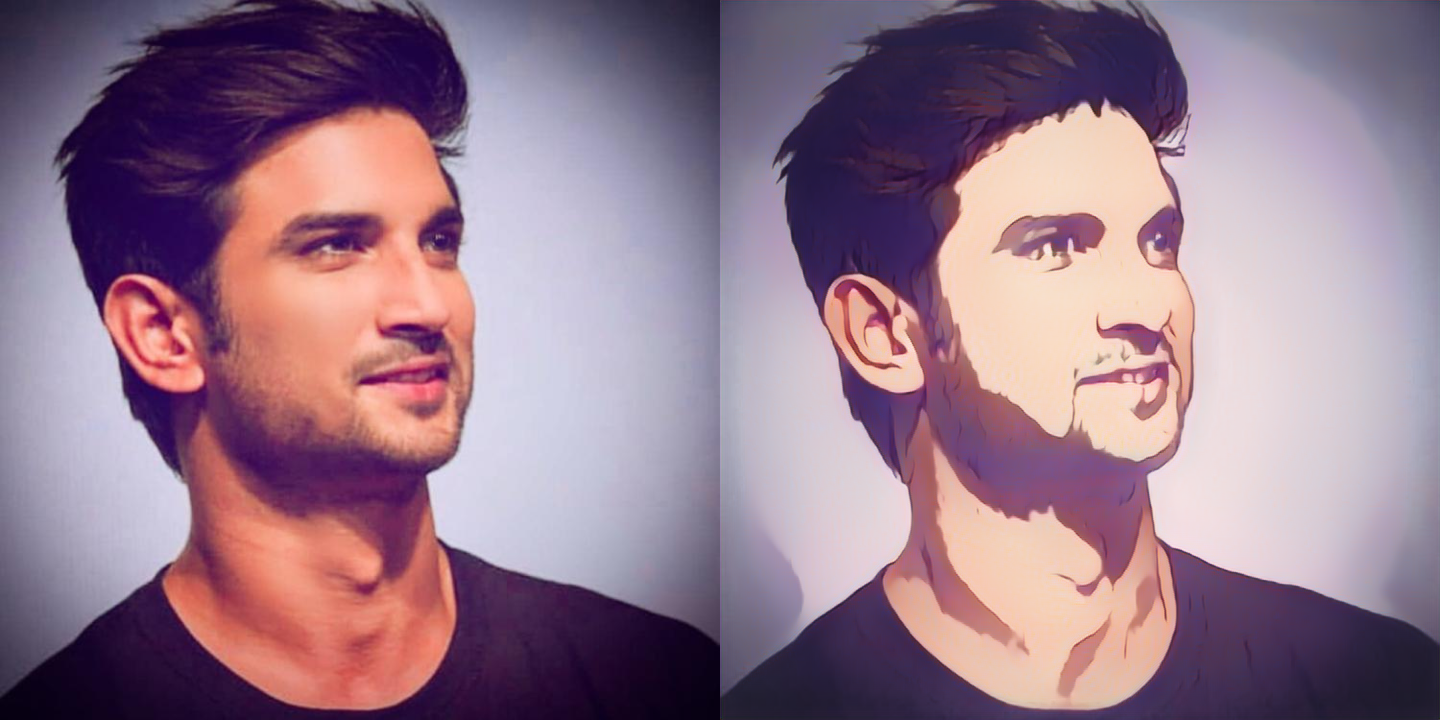

In [19]:
raw_image = cv2.imread('image.jpg')
img = resize_crop(raw_image)
image = img/127.5 - 1
image = image.transpose(2, 0, 1)
image = torch.tensor(image).unsqueeze(0)
output = model(image.float())
output = output.squeeze(0).detach().numpy()
output = output.transpose(1, 2, 0)
output = (output + 1) * 127.5
output = np.clip(output, 0, 255).astype(np.uint8)
output = np.concatenate([img, output], axis=1)
cv2.imwrite('output.jpg', output)
cv2_imshow(output)